<a href="https://colab.research.google.com/github/ua-datalab/Geospatial_Workshops/blob/main/notebooks/deepforest_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tree Detection with DeepForest

This jupyter notebook uses the python library DeepForest to identify and put bounding boxes around trees.

If using the software, please cite as:
Geographic Generalization in Airborne RGB Deep Learning Tree Detection Ben. G. Weinstein, Sergio Marconi, Stephanie A. Bohlman, Alina Zare, Ethan P. White bioRxiv 790071; doi: https://doi.org/10.1101/790071

Documentation for DeepForest can be found at https://deepforest.readthedocs.io/en/latest/index.html

In [1]:
#Install the deepforest python library. After installing, you may need to restart the kernel before moving to the next code snippet
!pip install DeepForest --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 52.8 MB/s eta 0:00:00


In [2]:
##After restarting the kernel, import libraries into environment...
from deepforest import main
from deepforest import get_data
from deepforest.utilities import boxes_to_shapefile
from deepforest.utilities import shapefile_to_annotations
from deepforest.preprocess import split_raster
from deepforest.visualize import plot_predictions

import matplotlib.pyplot as plt
import os
import time
import numpy
import rasterio
import geopandas as gpd
from rasterio.plot import show
import torch


In [6]:
#Bring a DeepForest pretrained model into environment. It is located at https://github.com/weecology/DeepForest/releases/tag/1.0.0
model = main.deepforest()
model.use_release()

Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 187MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


NEON.pt: 129MB [00:01, 72.5MB/s]                          
/usr/local/lib/python3.10/dist-packages/deepforest/main.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self

Model was downloaded and saved to /usr/local/lib/python3.10/dist-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


## Predict Tree Crowns on Raw (non-georeferenced images)

In [ ]:
#Path for the image you want to ID trees.
#These are non-georeferenced single jpeg drone image located in Cyverse datastore

!wget https://data.cyverse.org/dav-anon/iplant/commons/cyverse_curated/Gillan_Ecosphere_2021/raw_images/May_2019/15-g2/100_0123/100_0123_0086.JPG
image_path = get_data("/content/100_0123_0086.JPG")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/DJI_0184.jpeg
image_path2 = get_data("/content/DJI_0184.jpeg")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/100_0407_0064.jpeg
image_path3 = get_data("/content/100_0407_0064.jpeg")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/DJI_0468.jpeg
image_path4 = get_data("/content/DJI_0468.jpeg")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/101_0472_0074.jpeg
image_path5 = get_data("/content/101_0472_0074.jpeg")


In [ ]:
#Identify and put bounding boxes around all trees in the image
#This will create a table showing image coordinates of every predicted tree
#The 'score' is the confidence that the prediction is correct. Values closer to 1 are better.
trees = model.predict_image(path=image_path3, return_plot = False)
trees

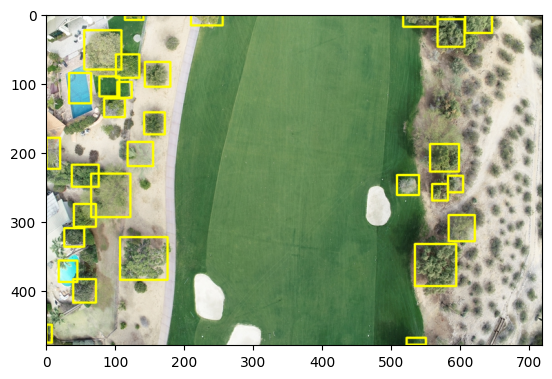

In [21]:
#Show the image with the bounding boxes
plot = model.predict_image(path=image_path3, return_plot = True, color=(0, 255, 255), thickness=2)
plt.imshow(plot[:,:,::-1])

## Predict Tree Crowns on Georeferenced Images

In [22]:
#Set the path for a georeferenced image you want to predict tree crowns

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif
raster_path = get_data("/content/hole_17_ortho_utm.tif")



--2024-09-09 23:11:40--  https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.35
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 734371555 (700M) [application/octet-stream]
Saving to: ‘hole_17_ortho_utm.tif’

hole_17_ortho_utm.t 100%[===================>] 700.35M   143MB/s    in 8.6s    

2024-09-09 23:11:50 (81.9 MB/s) - ‘hole_17_ortho_utm.tif’ saved [734371555/734371555]



In [23]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(255, 255, 0), thickness=20)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

5312 predictions in overlapping windows, applying non-max supression
3020 predictions kept after non-max suppression


/usr/local/lib/python3.10/dist-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


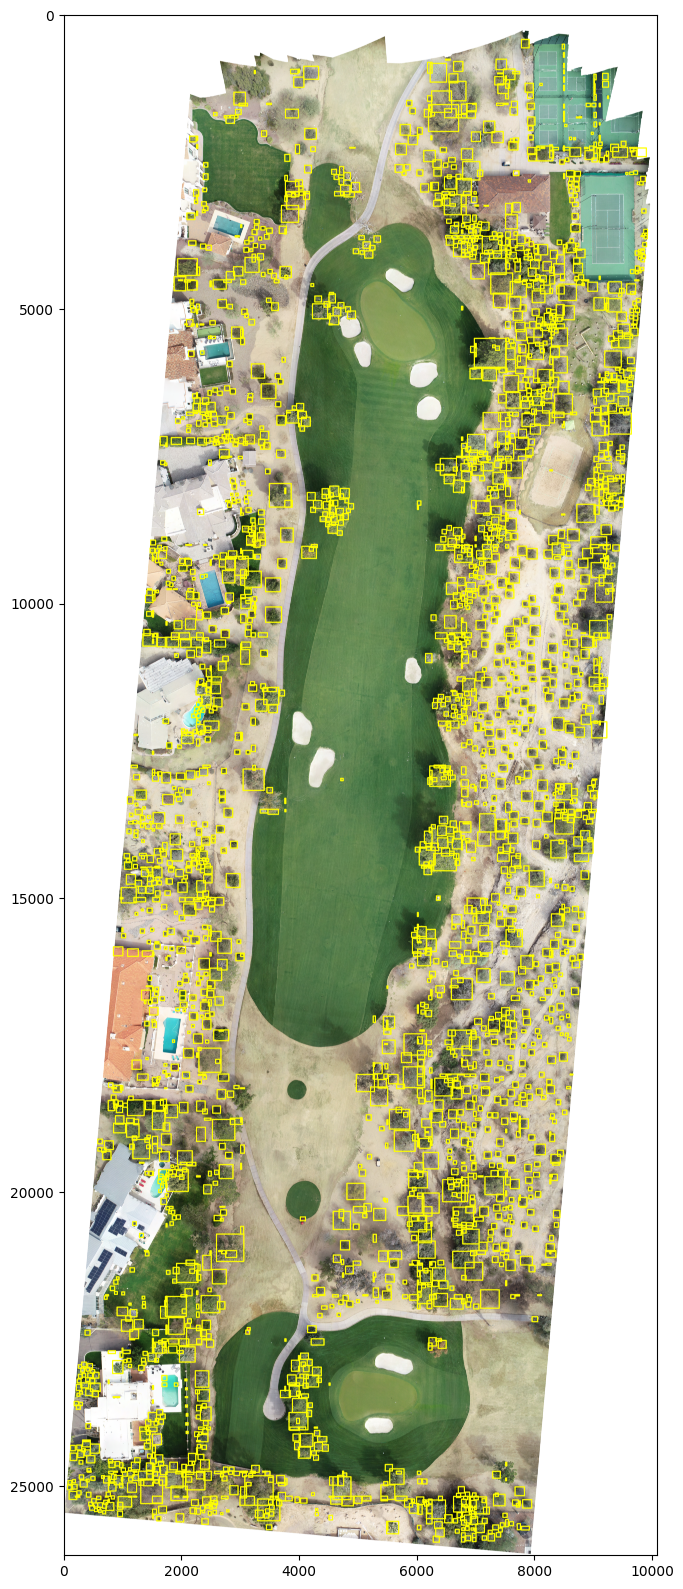

In [24]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Improve Model with Training
If the pre-trained model does not identify all trees correclty, then we want to improve the model by adding some training data and fine-tuning the model.
Manual labeling of trees (bounding boxes) can be done in QGIS. The output should be a polygon shapefile (.shp). Instructions for using QGIS is [here](https://github.com/ua-datalab/Geospatial_Workshops/wiki/Drone-Image-Analysis-%E2%80%90-Deep-Forest)

In [ ]:
#Define data paths in preparation to convert .shp to annotation dataframe that can be used for training
## I have found that it is important that the orthomosaic and shapefiles used should have map projections (e.g., UTM). Otherwise, there will be a shift problem in the `shapefile_to_annotations` step.

# training data imagery path
# We are using the golf course orthomosaic geotiff
train_image_path = get_data("/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif")


# the directory that has the training data imagery
train_image_dir = os.path.dirname(train_image_path)

# the name of the training imagery
image_name = os.path.basename(train_image_path)

# shapefile path
#shp_path = "/data-store/iplant/home/jgillan/media/golf_train_utm.shp"
shp_path = "/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.shp"

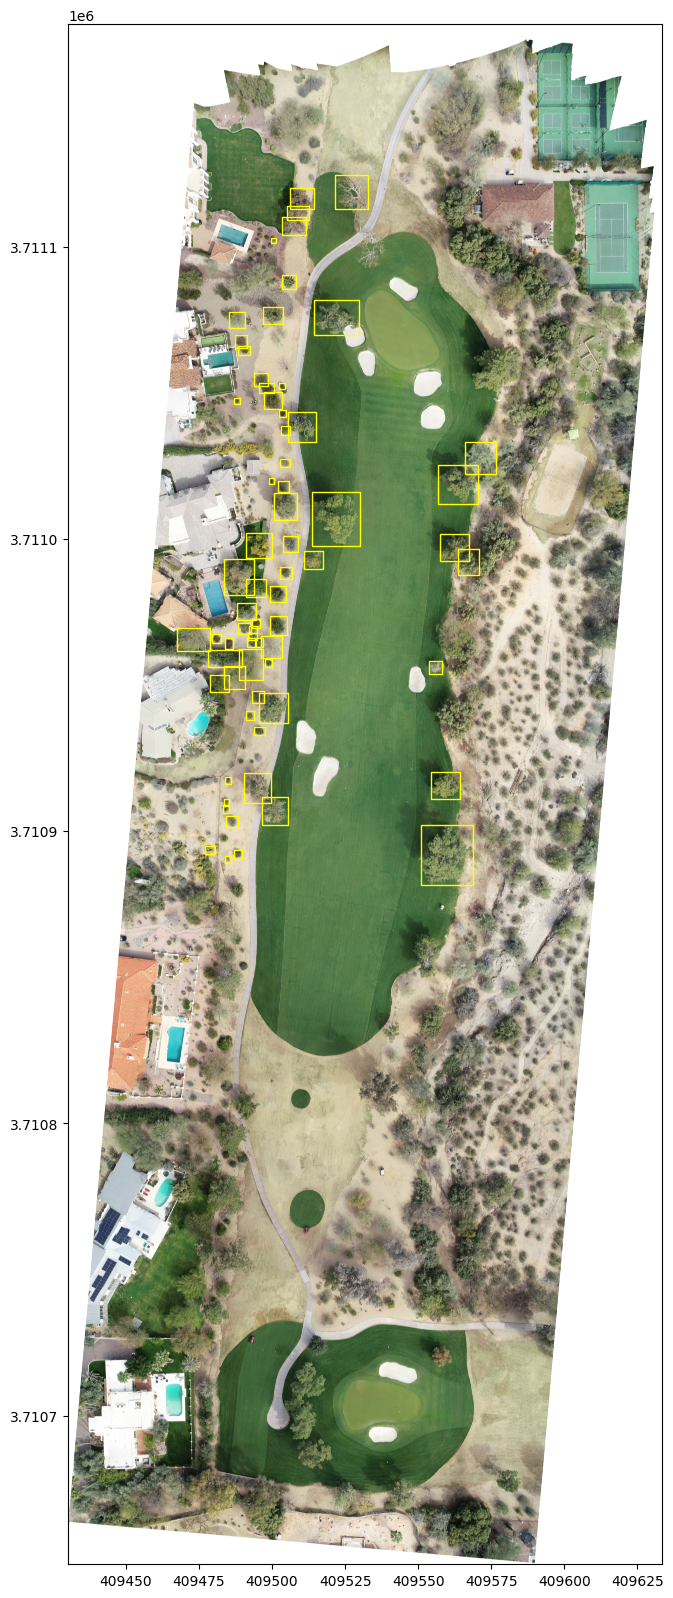

In [ ]:
## Show shapefile overlayed on orthomosaic

# Open the GeoTIFF file
with rasterio.open(train_image_path) as src:
    fig, ax = plt.subplots(figsize=(20, 20))
    show(src, ax=ax)

    # Read the shapefile
    shapefile = gpd.read_file(shp_path)

    # Plot the shapefile on top of the GeoTIFF
    shapefile.plot(ax=ax, facecolor='none', edgecolor='yellow')

plt.show()

In [ ]:
##Convert .shp (shapefile) to annoation that can be ingested by DeepForest
df = shapefile_to_annotations(shapefile=shp_path, rgb=train_image_path, geometry_type='bbox', savedir=savedir)

In [ ]:
#Write training annotation dataframe to csv file
#ATTENTION!!! You need to change the path to YOUR datastore directory. Change .../jgillan to your Cyverse username
savedir = "/data-store/iplant/home/jgillan/media"
df.to_csv(os.path.join(savedir, "labels_pixel_coords.csv"), index=False)

In [ ]:
#Show the annotation
df

image_path  xmin   ymin  xmax   ymax label
0   hole_17_ortho_utm.tif  3655   8704  3899   8969  Tree
1   hole_17_ortho_utm.tif  4011   8958  4332   9254  Tree
2   hole_17_ortho_utm.tif  3502   7961  3894   8424  Tree
3   hole_17_ortho_utm.tif  3013   8653  3461   9075  Tree
4   hole_17_ortho_utm.tif  3604   9223  3802   9427  Tree
..                    ...   ...    ...   ...    ...   ...
63  hole_17_ortho_utm.tif  2323  13966  2486  14108  Tree
64  hole_17_ortho_utm.tif  2823  14037  2954  14179  Tree
65  hole_17_ortho_utm.tif  2660  14139  2762  14250  Tree
66  hole_17_ortho_utm.tif  2641  13169  2736  13280  Tree
67  hole_17_ortho_utm.tif  2633  13272  2739  13398  Tree

[68 rows x 6 columns]

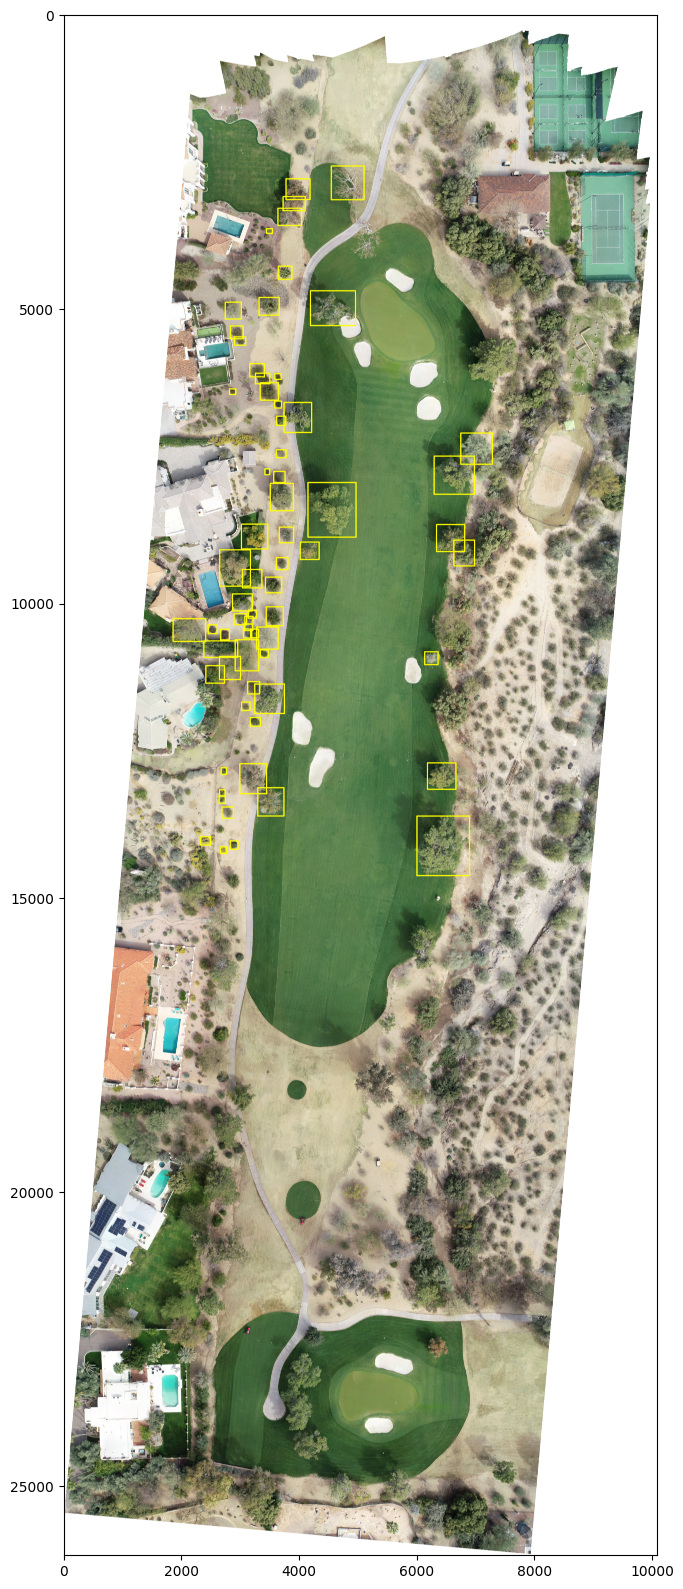

In [ ]:
## Display the annotation on the orthomosaic

rasterio_src = rasterio.open(train_image_path)

image = rasterio_src.read()
image = numpy.rollaxis(image, 0, 3)

fig = plot_predictions(image, df, color=(255, 255, 0), thickness=20)
plt.figure(figsize=(20, 20))
plt.imshow(fig)

In [ ]:
##This will split a large georeferenced image (and it's labels) into smaller pieces. This prevents running out of memory.
annotation_path = os.path.join(savedir, "labels_pixel_coords.csv")

#create a directory where the smaller images will be stored
crop_dir = os.path.join(savedir, 'train_data')

# Do the split and write out the cropped images as .png files.
#Also write a new annotation table (csv) that lists all of the label coordinates and the cropped image they belong to.
output_crops = split_raster(path_to_raster=train_image_path,
                            annotations_file=annotation_path,
                            base_dir=crop_dir,
                            patch_size=1100,  #1100x1100 pixels
                            patch_overlap=0.25, #cropped image overlap. This is useful because label boxes may be on the edge of cropped images.
                            allow_empty=False)

print(f"Number of tree crown annotations: {len(output_crops)}")
output_crops

Number of tree crown annotations: 81


image_path  xmin  ymin  xmax  ymax label
26   hole_17_ortho_utm_76.png   798   465   950   615  Tree
56   hole_17_ortho_utm_76.png   202   360   756   746  Tree
52   hole_17_ortho_utm_77.png   759   334  1074   631  Tree
61   hole_17_ortho_utm_79.png  1018   419  1100   532  Tree
66   hole_17_ortho_utm_79.png   991   794  1086   905  Tree
..                        ...   ...   ...   ...   ...   ...
10  hole_17_ortho_utm_234.png   551   410  1030   869  Tree
39  hole_17_ortho_utm_237.png   351    98   577   316  Tree
57  hole_17_ortho_utm_239.png   397   336   881   785  Tree
8   hole_17_ortho_utm_264.png   139   505   674  1035  Tree
11  hole_17_ortho_utm_266.png    21   675   373  1100  Tree

[81 rows x 6 columns]

### Split annotation data into training and validation

In [ ]:
#identify all of the cropped images as an array
image_paths = output_crops.image_path.unique()

#Of the unique cropped image paths, randomly select 25% of them
validation_paths = numpy.random.choice(image_paths, int(len(image_paths)*0.25))

#Get the individual tree annotation from the 25% cropped images
validation_annotations = output_crops.loc[output_crops.image_path.isin(validation_paths)]

#Get the individual tree annotations from the remaining 75% cropped images
train_annotations = output_crops.loc[~output_crops.image_path.isin(validation_paths)]

#Print out the number of training and testing tree crown annotations
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(validation_annotations.shape[0]))

There are 66 training crown annotations
There are 15 test crown annotations


In [ ]:
## Write training and validation annotations to separate csv files

#save to file and create the file dir
training_file= os.path.join(crop_dir,"train.csv")
validation_file= os.path.join(crop_dir,"valid.csv")
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(training_file,index=False)
validation_annotations.to_csv(validation_file,index=False)

## Train

In [ ]:
##Set parameters for the training run

#Define the pre-trained model
model = main.deepforest()

model.config['gpus'] = '-1' #move to GPU and use all the GPU resources

#model.config["save-snapshot"] = False
#model.config["train"]["fast_dev_run"] = True

#The annotation table
model.config["train"]["csv_file"] = training_file
#The directory where the training imagery is located
model.config["train"]["root_dir"] = os.path.dirname(training_file)

model.config["score_thresh"] = 0.4
model.config["train"]['epochs'] = 4

model.config["validation"]["csv_file"] = validation_file
model.config["validation"]["root_dir"] = os.path.dirname(validation_file)


model.create_trainer()

model.use_release()


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [ ]:
##TRAIN THE MODEL!
#You can watch the GPU usage by using nvtop (sudo apt install nvtop)
start_time = time.time()
model.trainer.fit(model)
print(f"--- Training on GPU: {(time.time() - start_time):.2f} seconds ---")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name       | Type                  | Params
-----------------------------------------------------
0 | model      | RetinaNet             | 32.1 M
1 | iou_metric | IntersectionOverUnion | 0     
2 | mAP_metric | MeanAveragePrecision  | 0     
-----------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/opt/conda/lib/python3.11/site-packages/deepforest/evaluate.py:193: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results)
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 26/26 [00:12<00:00,  2.15it/s, v_num=2]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:07<00:00,  3.40it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:07<00:00,  3.66it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:07<00:00,  3.65it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:09<00:00,  2.88it/s, v_num=2]     

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 26/26 [00:09<00:00,  2.88it/s, v_num=2]
--- Training on GPU: 47.59 seconds ---


## Save and load the fine-tuned model

In [ ]:
#Save the fine-tuned model out to your Cyverse Datastore
save_model_dir = os.path.join(savedir, 'golf_course_deepforest.pt')
torch.save(model.model.state_dict(),save_model_dir)

In [ ]:
#Bring existing model into environment
fine_tuned_model = main.deepforest()
fine_tuned_model.model.load_state_dict(torch.load(save_model_dir))

Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


<All keys matched successfully>

## Visualize the prediction after model fine-tuning

In [ ]:
#Set the path for a georeferenced image you want to predict tree crowns
raster_path = get_data("/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif")

In [ ]:
##Predict tree crowns on a georeferenced image
predicted_raster = fine_tuned_model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(255, 255, 0), thickness=20)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 490/490 [00:43<00:00, 11.15it/s]
1827 predictions in overlapping windows, applying non-max supression
1084 predictions kept after non-max suppression


/opt/conda/lib/python3.11/site-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


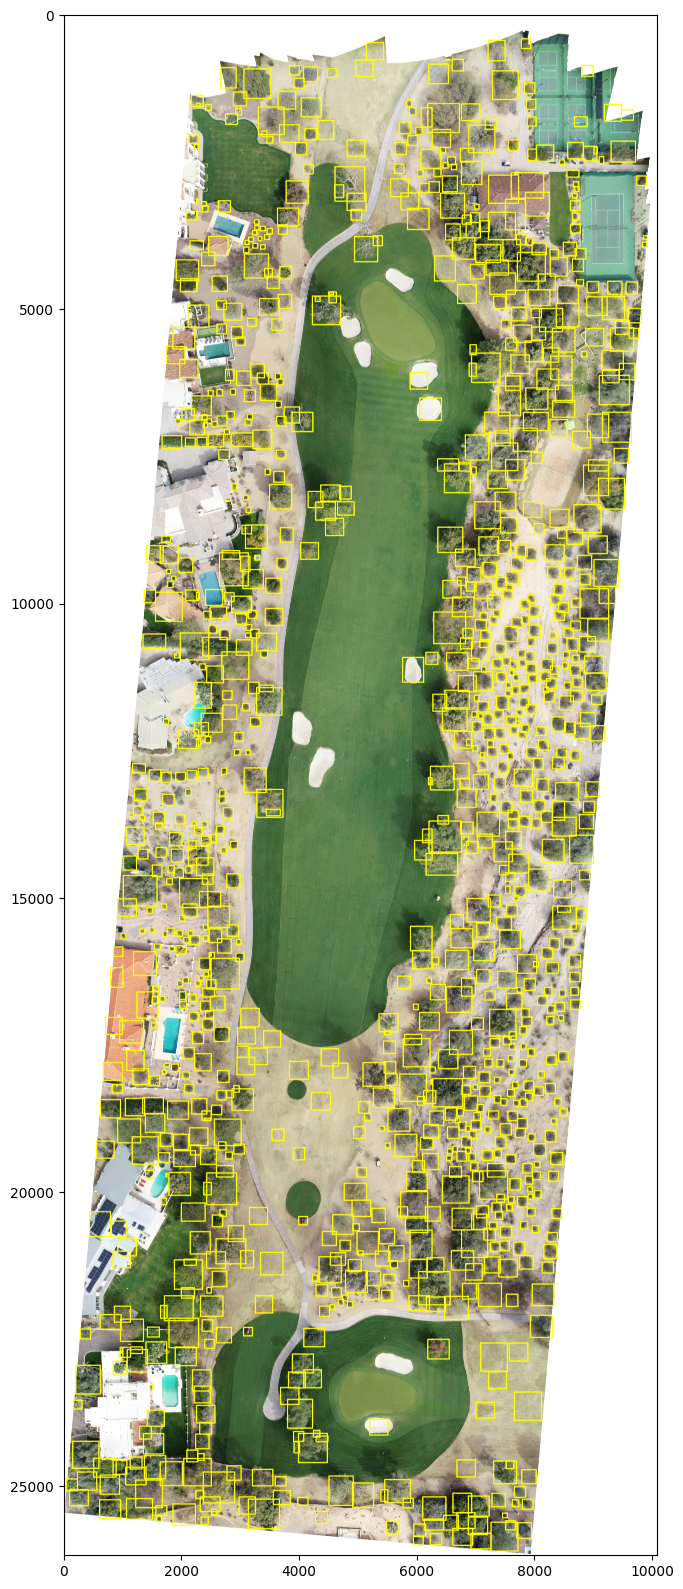

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Output and save prediction results for each image crop

In [ ]:
save_dir = os.path.join(savedir, 'pred_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(training_file, os.path.dirname(training_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 26/26 [00:15<00:00,  1.72it/s]


/opt/conda/lib/python3.11/site-packages/deepforest/IoU.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  iou_df = pd.concat(iou_df)


In [ ]:
## Output and save validation results for each image crop

In [ ]:
save_dir = os.path.join(savedir, 'valid_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(validation_file, os.path.dirname(validation_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


## Assessing the Quality of our Tree Predictions

In [ ]:
#show assessment of results
results

{'results':    prediction_id  truth_id       IoU     score  xmin  xmax  ymin  ymax  \
 0              0         0  0.793611  0.577225   964  1064   331   412   
 0              0         0  0.791331  0.665586   538   986   403   825   
 0              2         0  0.767934  0.669327   348   479    12   154   
 1              1         1  0.844136  0.711848   185   287   114   225   
 0              0         0  0.862957  0.815043   202   594   536   999   
 1              4         1  0.728934  0.391279   304   470     0    99   
 2              2         2  0.840898  0.574207   262   454   333   522   
 3              1         3  0.861870  0.649530   112   194   288   388   
 0              0         0  0.810587  0.801073   133   423   158   479   
 1              1         1  0.785961  0.689490    36   168   891  1023   
 2              2         2  0.784958  0.252513     0   336   502   878   
 0              0         0  0.631586  0.697379   139   674   505  1035   
 0            

In [ ]:
results['results']

prediction_id  truth_id       IoU     score  xmin  xmax  ymin  ymax  \
0              0         0  0.793611  0.577225   964  1064   331   412   
0              0         0  0.791331  0.665586   538   986   403   825   
0              2         0  0.767934  0.669327   348   479    12   154   
1              1         1  0.844136  0.711848   185   287   114   225   
0              0         0  0.862957  0.815043   202   594   536   999   
1              4         1  0.728934  0.391279   304   470     0    99   
2              2         2  0.840898  0.574207   262   454   333   522   
3              1         3  0.861870  0.649530   112   194   288   388   
0              0         0  0.810587  0.801073   133   423   158   479   
1              1         1  0.785961  0.689490    36   168   891  1023   
2              2         2  0.784958  0.252513     0   336   502   878   
0              0         0  0.631586  0.697379   139   674   505  1035   
0              2         0  0.664979  0.290820    21   373   675  1100   
0              1         0  0.798563  0.543633   798   950   465   615   
1              0         1  0.586447  0.632223   202   756   360   746   

  predicted_label true_label                 image_path  match  
0            Tree       Tree  hole_17_ortho_utm_100.png   True  
0            Tree       Tree  hole_17_ortho_utm_106.png   True  
0            Tree       Tree  hole_17_ortho_utm_113.png   True  
1            Tree       Tree  hole_17_ortho_utm_113.png   True  
0            Tree       Tree  hole_17_ortho_utm_137.png   True  
1            Tree       Tree  hole_17_ortho_utm_137.png   True  
2            Tree       Tree  hole_17_ortho_utm_137.png   True  
3            Tree       Tree  hole_17_ortho_utm_137.png   True  
0            Tree       Tree  hole_17_ortho_utm_140.png   True  
1            Tree       Tree  hole_17_ortho_utm_140.png   True  
2            Tree       Tree  hole_17_ortho_utm_140.png   True  
0            Tree       Tree  hole_17_ortho_utm_264.png   True  
0            Tree       Tree  hole_17_ortho_utm_266.png   True  
0            Tree       Tree   hole_17_ortho_utm_76.png   True  
1            Tree       Tree   hole_17_ortho_utm_76.png   True

In [ ]:
results['box_precision']

0.4140796703296703

In [ ]:
results["box_recall"]

1.0

In [ ]:
results["class_recall"]

label  recall  precision  size
0      0     1.0        1.0    15